In [1]:
!pip3 install pandas matplotlib  geopandas 
!pip3 install descartes shifterator
!pip3 install wordcloud gensim nltk networkx

  Using cached networkx-2.5.1-py3-none-any.whl (1.6 MB)


In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from wordcloud import WordCloud
from gensim import corpora, models
import geopandas as gpd
import shifterator as sh
import nltk
from nltk.corpus import stopwords
import networkx as nx

/home/wva/ccsbook/env/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [3]:
tw=pd.read_csv("https://cssbook.net/d/covid.csv")
tw.head()

,status_id,created_at,screen_name,lang,location,text,retweet_count,reply_to_screen_name
0,1309535775109926912,2020-09-25T16:50:33Z,ghulamabbasshah,en,"Lahore, Pakistan",Secularism of #Gandhi and #Nehru in #India has...,1203,NaN
1,1309626010221129729,2020-09-25T22:49:07Z,GeoRebekah,en,"Florida, USA",On the day @GovRonDeSantis rejects the experts...,1146,NaN
2,1309578234007257088,2020-09-25T19:39:16Z,AlexBerenson,en,New York,Updated @cgcgov figures: 66 children under 15 ...,988,NaN
3,1309557875296083969,2020-09-25T18:18:22Z,AlexBerenson,en,New York,No mo ro in Flo: @govrondesantis proves again ...,953,NaN
4,1309643186827132929,2020-09-25T23:57:22Z,B52Malmet,en,"New York, NY",Dr. Fauci warns the worst public health crisis...,946,NaN


<AxesSubplot:xlabel='created_at'>

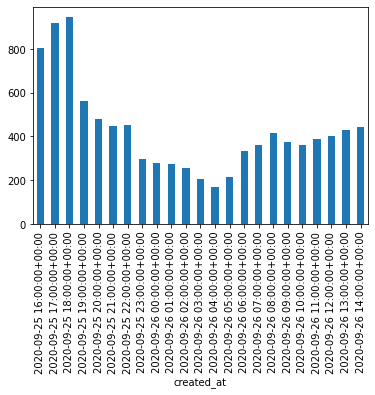

In [4]:
tw.index=pd.DatetimeIndex(tw["created_at"])
tw["status_id"].groupby(pd.Grouper(freq="H")) \
    .count().plot(kind="bar")
# (note the use of \ to split a long line)

(-0.5, 399.5, 199.5, -0.5)

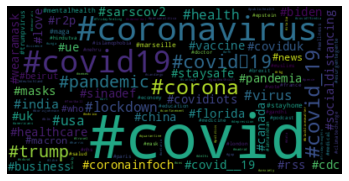

In [5]:
freq = defaultdict(int)
for tweet in tw["text"]:
    for hashtag in re.findall("#\w+", tweet):
            freq[hashtag.lower()]+=1
wc = WordCloud().generate_from_frequencies(freq)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

In [6]:
tags = [[tag.lower() 
         for tag in re.findall("#\w+", tweet)] 
        for tweet in tw["text"]]
voca = corpora.Dictionary(tags)
corpus = [voca.doc2bow(doc) for doc in tags]
m = models.LdaModel(corpus, num_topics=10,
  id2word=voca,
  distributed=False, random_state=123)
m.print_topics()

[(0,
  '0.030*"#coviduk" + 0.019*"#covid" + 0.010*"#lockdown2" + 0.007*"#police" + 0.006*"#crisis" + 0.005*"#dengue" + 0.004*"#portland" + 0.004*"#durango" + 0.004*"#salerno" + 0.003*"#politica"'),
 (1,
  '0.132*"#covid" + 0.016*"#salud" + 0.012*"#blm" + 0.008*"#fridayvibes" + 0.006*"#africa" + 0.006*"#safety" + 0.005*"#sugar" + 0.005*"#ethanol" + 0.005*"#francia" + 0.005*"#rbob"'),
 (2,
  '0.105*"#covid" + 0.030*"#vaccine" + 0.029*"#lockdown" + 0.014*"#quarantine" + 0.008*"#campania" + 0.007*"#sports" + 0.007*"#economy" + 0.007*"#unga" + 0.006*"#unemployment" + 0.006*"#covidtesting"'),
 (3,
  '0.151*"#covid" + 0.112*"#covid19" + 0.067*"#coronavirus" + 0.048*"#covid_19" + 0.045*"#corona" + 0.023*"#covidー19" + 0.012*"#biden" + 0.010*"#sarscov2" + 0.009*"#covid__19" + 0.007*"#coronainfoch"'),
 (4,
  '0.664*"#covid" + 0.010*"#covidー19" + 0.005*"#covidiots" + 0.005*"#masks" + 0.004*"#cdc" + 0.004*"#covid19" + 0.004*"#podcast" + 0.003*"#marseille" + 0.003*"#nhs" + 0.003*"#youtube"'),
 (5,
 

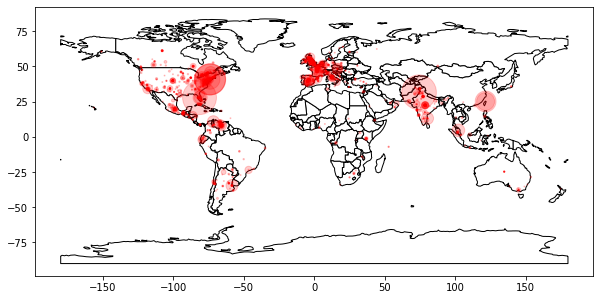

In [7]:
url = "https://cssbook.net/d/covid_users.csv"
users = pd.read_csv(url)
tw2 = tw.merge(users,on="screen_name",how="left")
world = gpd.read_file(
  gpd.datasets.get_path("naturalearth_lowres"))
gdf = gpd.GeoDataFrame(tw2, 
  geometry=gpd.points_from_xy(tw2.long, tw2.lat))
ax = world.plot(color="white", edgecolor="black", 
                figsize=(10,10))
gdf.plot(ax=ax, color="red", alpha=.2,
         markersize=tw["retweet_count"])
plt.show()

[nltk_data] Downloading package stopwords to /home/wva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/wva/ccsbook/env/lib/python3.8/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


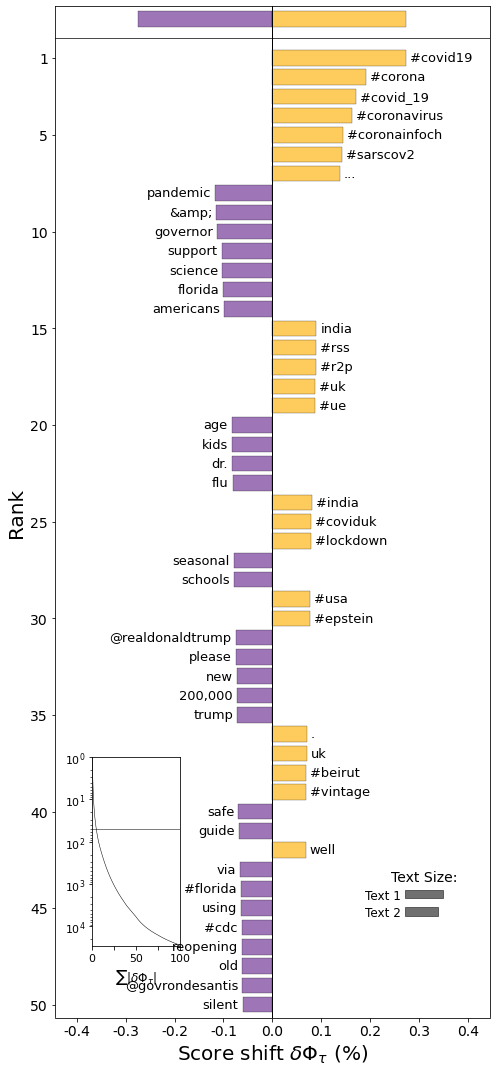

<AxesSubplot:xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [8]:
nltk.download("stopwords")
cn = gdf.query("lang=='en'&(long<-60 & lat>25)")
cn = Counter(cn["text"].str.cat().lower().split())
cr = gdf.query("lang=='en' & (long>-60 | lat<25)")
cr = Counter(cr["text"].str.cat().lower().split())
for k in stopwords.words("english"):
    del cn[k]
    del cr[k]
key = sh.ProportionShift(type2freq_1=cn,
                         type2freq_2=cr)
key.get_shift_graph()

In [9]:
edges=tw2[["screen_name","reply_to_screen_name"]]
edges=edges.dropna().rename({"screen_name":"from",
  "reply_to_screen_name":"to"}, axis="columns")
edges.groupby(["from","to"]).size().head()

from            to            
007Vincentxxx   ilfattovideo      1
06CotedUsure    ArianeWalter      1
1Million4Covid  1Million4Covid    3
                JustinTrudeau     1
1ctboy1         LegionPost13      1
dtype: int64

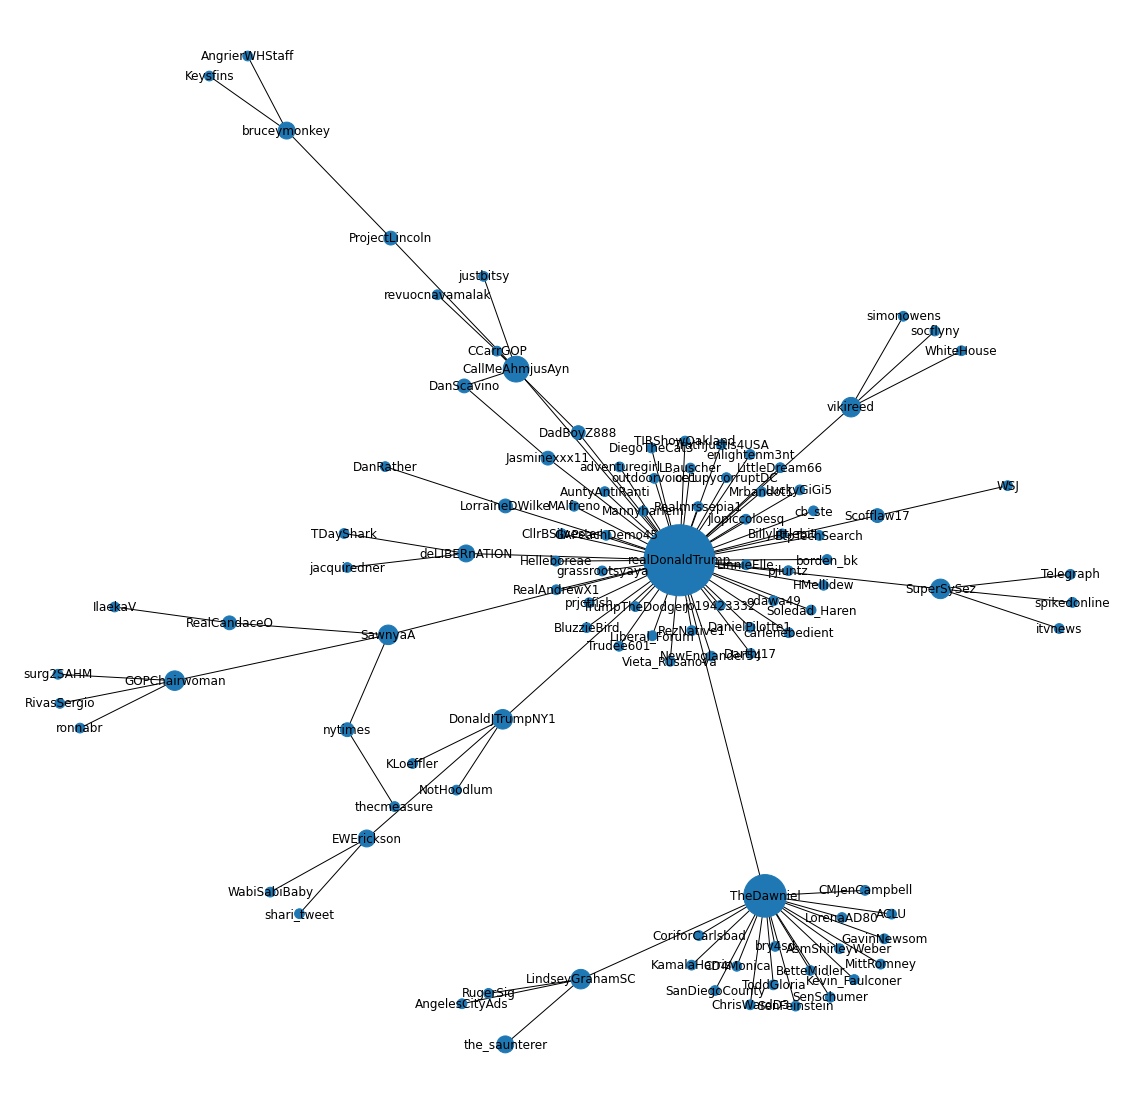

In [10]:
g1 = nx.Graph()
g1.add_edges_from(edges.to_numpy())
largest = max(nx.connected_components(g1),key=len)
g2 = g1.subgraph(largest)

pos = nx.spring_layout(g2)
plt.figure(figsize=(20,20))
plt.axis("off")
sizes = [s*1e4 for s in 
  nx.centrality.degree_centrality(g2).values()]
nx.draw_networkx_nodes(g2,pos, node_size=sizes)
nx.draw_networkx_labels(g2,pos)
nx.draw_networkx_edges(g2,pos)
plt.show()

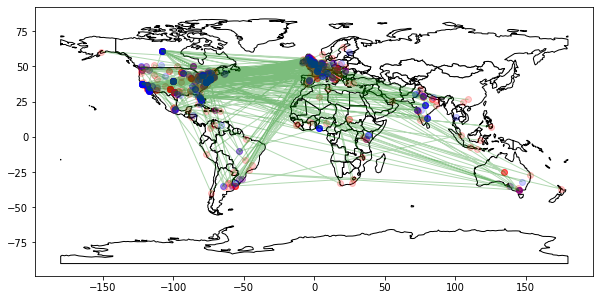

In [11]:
u = users.drop(["location"], axis=1)
uf = u.rename({"screen_name":"from",
    "lat":"lat_from","long":"long_from"}, axis=1)
ut = u.rename({"screen_name":"to",
    "lat":"lat_to","long":"long_to"}, axis=1)
edges = edges.merge(uf).merge(ut).query(
    "long_to!=long_from & lat_to!=lat_from")

world = gpd.read_file(
    gpd.datasets.get_path("naturalearth_lowres"))
g_to = gpd.GeoDataFrame(edges.copy(),
    geometry=gpd.points_from_xy(edges.long_to,
                                edges.lat_to))
g_from = gpd.GeoDataFrame(edges.copy(),
    geometry=gpd.points_from_xy(edges.long_from,
                                edges.lat_from))

ax = world.plot(color="white", edgecolor="black",
                figsize=(10,10))
g_from.plot(ax=ax, color="red", alpha=.2)
g_to.plot(ax=ax, color="blue", alpha=.2)

e=g_from.join(g_to, lsuffix="_from",rsuffix="_to")
e = e[["geometry_from", "geometry_to"]]
px = lambda point: point.x
py = lambda point: point.y
x_values = list(zip(e["geometry_from"].map(px),
                    e["geometry_to"].map(px)))
y_values = list(zip(e["geometry_from"].map(py),
                    e["geometry_to"].map(py)))
plt.plot(x_values, y_values, linewidth = 1,
    linestyle = "-", color = "green", alpha=.3)
plt.show()